# Realistic Ocean Simulations in pure Julia

In this tutorial we will build a global ocean simulation using the ClimaOcean and Oceananigans Julia packages.
The simulation will be at a nominal four-degree with parameterizations for mesoscale eddies and vertical mixing.
We will set up the grid, download and interpolate the bathymetry,
download forcing files, and finally set up and run the simulation

## Required software

The tutorial is quite computationally expensive, therefore, if you have
access, it is recommended to run the tutorial on one GPU.
However, for the purpose of understanding how the library works,
a 2 degree global ocean model runs comfortably on a laptop.

## Packages:

Let's start by importing the necessary packages, these are:
- ClimaOcean: the ocean model
- Oceananigans: the fluid dynamics library doing the heavy lifting
- Printf: always useful for spitting out output
- CairoMakie: visualization package to visualize the results

In [1]:
using Pkg
Pkg.activate("./")

using ClimaOcean
using Oceananigans
using Oceananigans.Units
using Oceananigans.Grids
using Dates
using Printf
using CairoMakie

  Activating project at `~/development/EGU2025-Julia-intro-and-showcase-for-geoscience/global-ocean-notebooks`
┌ Warning: Error requiring `IntervalArithmetic` from `TaylorSeries`
│   exception =
│    LoadError: UndefVarError: `IntervalBox` not defined
│    Stacktrace:
│      [1] top-level scope
│        @ ~/.julia/packages/TaylorSeries/ZBRjU/src/intervals.jl:171
│      [2] include(mod::Module, _path::String)
│        @ Base ./Base.jl:495
│      [3] include(x::String)
│        @ TaylorSeries ~/.julia/packages/TaylorSeries/ZBRjU/src/TaylorSeries.jl:17
│      [4] top-level scope
│        @ ~/.julia/packages/Requires/1eCOK/src/Requires.jl:40
│      [5] eval
│        @ ./boot.jl:385 [inlined]
│      [6] eval
│        @ ~/.julia/packages/TaylorSeries/ZBRjU/src/TaylorSeries.jl:17 [inlined]
│      [7] (::TaylorSeries.var"#54#57")()
│        @ TaylorSeries ~/.julia/packages/Requires/1eCOK/src/require.jl:101
│      [8] macro expansion
│        @ timing.jl:395 [inlined]
│      [9] err(f::Any, lis

# Building a Global Ocean domain

We will start building a global ocean in steps:
- (1) specifying an **Architecture**
- (2) choosing a **Vertical coordinate**
- (2) Building a **Grid**
- (3) Downloading an interpolating a **Bathymetry**

### Architectures

using an architecture is easy...
it is possible to choose between:
- (1) CPU
- (2) GPU
- (3) Distributed

In this case, we select `CPU()`, which is always the right choice to start prototyping. Building the script on CPUs is better to catch potential bugs in the script.
Once we know that everything works correctly, we can just change the following line to `arch = GPU()`, and voilá, the simulation runs on GPUs

In [2]:
arch = CPU()

CPU()

### Vertical coordinates

Oceananigans currently supports only $z$ and $z^\star$ coordinates.
ClimaOcean provides a simple utility to build a simple exponential vertical coordinate

In [3]:
depth   = 6000meters
Nz      = 10
r_faces = ClimaOcean.exponential_z_faces(; Nz, depth)

11-element Vector{Float64}:
 -6000.0
 -3801.344048375254
 -2399.4191178885567
 -1505.5123157498406
  -935.5321737800014
  -572.0967893946568
  -340.3601570150809
  -192.59835644783735
   -98.38127267184085
   -38.30580769255842
     0.0

To use z-star coordinates we need to use a `z_faces = MutableVerticalDiscetization(r_faces)`, as opposed to a to
a `StaticVerticalDiscretization`, to set up the data structures required for a free-surface
following vertical coordinate.

In [4]:
z_faces = MutableVerticalDiscretization(r_faces)

MutableVerticalDiscretization{Vector{Float64}, Vector{Float64}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}([-6000.0, -3801.344048375254, -2399.4191178885567, -1505.5123157498406, -935.5321737800014, -572.0967893946568, -340.3601570150809, -192.59835644783735, -98.38127267184085, -38.30580769255842, 0.0], [-6000.0, -3801.344048375254, -2399.4191178885567, -1505.5123157498406, -935.5321737800014, -572.0967893946568, -340.3601570150809, -192.59835644783735, -98.38127267184085, -38.30580769255842, 0.0], nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing)

## Building a grid

ClimaOcean allows building ocean simulations on three different grid types:
- `RectilinearGrid`s which represent a _box_ or a Cartesian domain
- `LatitudeLongitudeGrid`s, which discretizes the sphere along latitude and longitude lines
- `OrthogonalSphericalShellGrid`s which discretize the sphere with two-dimensional coordinates that do not need to follow latitude and longitude lines.
   The only constraint is that the grid must be locally orthogonal in the horizontal direction.

`LatitudeLongitudeGrid`s are the easiest grids to work with since coordinates are one-dimensional and globally orthogonal.
(i.e. latitude depends only on the `j`-index and longitude depends only on the `i`-index)
However, `LatitudeLongitudeGrid`s have the problem of the zonal spacing approaching zero as we move to the poles.

For this reason, to represent a global ocean we use a specific type of `OrthogonalSphericalShellGrid`,
called `TripolarGrid` that discretizes the sphere as a set of perpendicular ellipses and hyperbolae.

Let's build a coarse `TripolarGrid` (about 4 degree resolution).
We pass to the grid, the architecture, the floating point precision, the size of the grid, and the vertical coordinate.

In [13]:
Nx   = 256 # longitudinal direction -> 256 points is about 1.5ᵒ resolution
Ny   = 128 # meridional direction -> same thing, 128 points is about 1.5ᵒ resolution
Nz   = length(r_faces) - 1
grid = TripolarGrid(arch, Float64; size=(Nx, Ny, Nz), z=z_faces)

256×128×10 OrthogonalSphericalShellGrid{Float64, Periodic, RightConnected, Bounded} on CPU with 4×4×4 halo and with precomputed metrics
├── centered at (λ, φ) = (70.0, 1.8005)
├── longitude: Periodic  extent 360.153 degrees       variably spaced with min(Δλ)=0.014941, max(Δλ)=1.48183
├── latitude:  RightConnected  extent 171.328 degrees variably spaced with min(Δφ)=0.022547, max(Δφ)=1.33858
└── z:         Bounded  z ∈ [-6000.0, 0.0]            variably spaced with min(Δr)=38.3058, max(Δr)=2198.66 (mutable)

#### Let's visualize the grid using CairoMakie

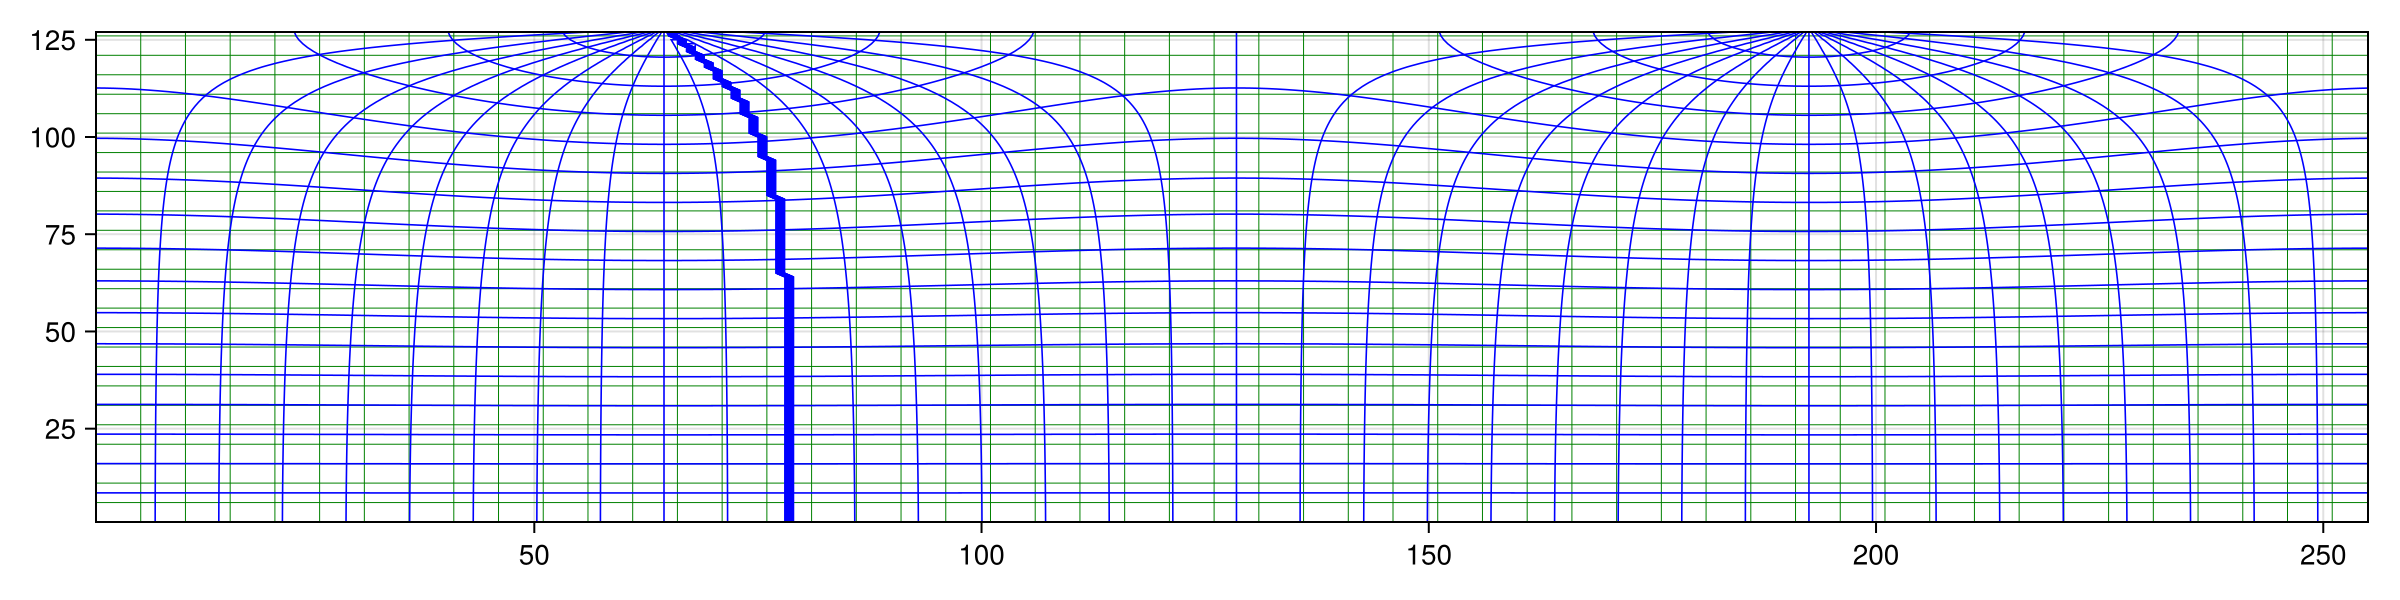

CairoMakie.Screen{IMAGE}


In [14]:
cartesian_nodes, _ = Oceananigans.Utils.get_cartesian_nodes_and_vertices(grid, Face(), Face(), Center())
xF, yF, zF = cartesian_nodes

cartesian_nodes, _ = Oceananigans.Utils.get_cartesian_nodes_and_vertices(grid, Center(), Center(), Center())
xC, yC, zC = cartesian_nodes

φ = Oceananigans.Grids.φnodes(grid, Center(), Center())
λ = Oceananigans.Grids.λnodes(grid, Center(), Center())

fig = Figure(size=(1200, 300))
axC = Axis(fig[1, 1])
[vlines!(axC, i, color = :green, linewidth=0.5) for i in 1:5:Nx]
[hlines!(axC, j, color = :green, linewidth=0.5) for j in 1:5:Ny]
contour!(axC, φ, levels=-80:10:90, color=:blue, linewidth=0.8)
contour!(axC, λ, levels=0:10:360,  color=:blue, linewidth=0.8)
xlims!(axC, 1, Nx-1)
ylims!(axC, 1, Ny-1)

display(fig)

## Adding a bathymetry to the grid

ClimaOcean provides a nifty utility to regrid the bathymetry over the grid, the `regrid_bathymetry` function.
By default ClimaOcean downloads the ETOPO_2022 bathymetry at 1/60ᵒ resolution (459 MB) from the NOAA servers.
!!! NOTE: This will download the ETOPO_2022 bathymetry, so make sure that you have an internet connection

┌ Info: Skipping passes for interpolating bathymetry of size (21600, 10800, 1) 
│ to target grid of size (256, 128, 10). Interpolation passes may only 
│ be used to coarsen bathymetry and require that the bathymetry 
└ is finer than the target grid in both horizontal directions.


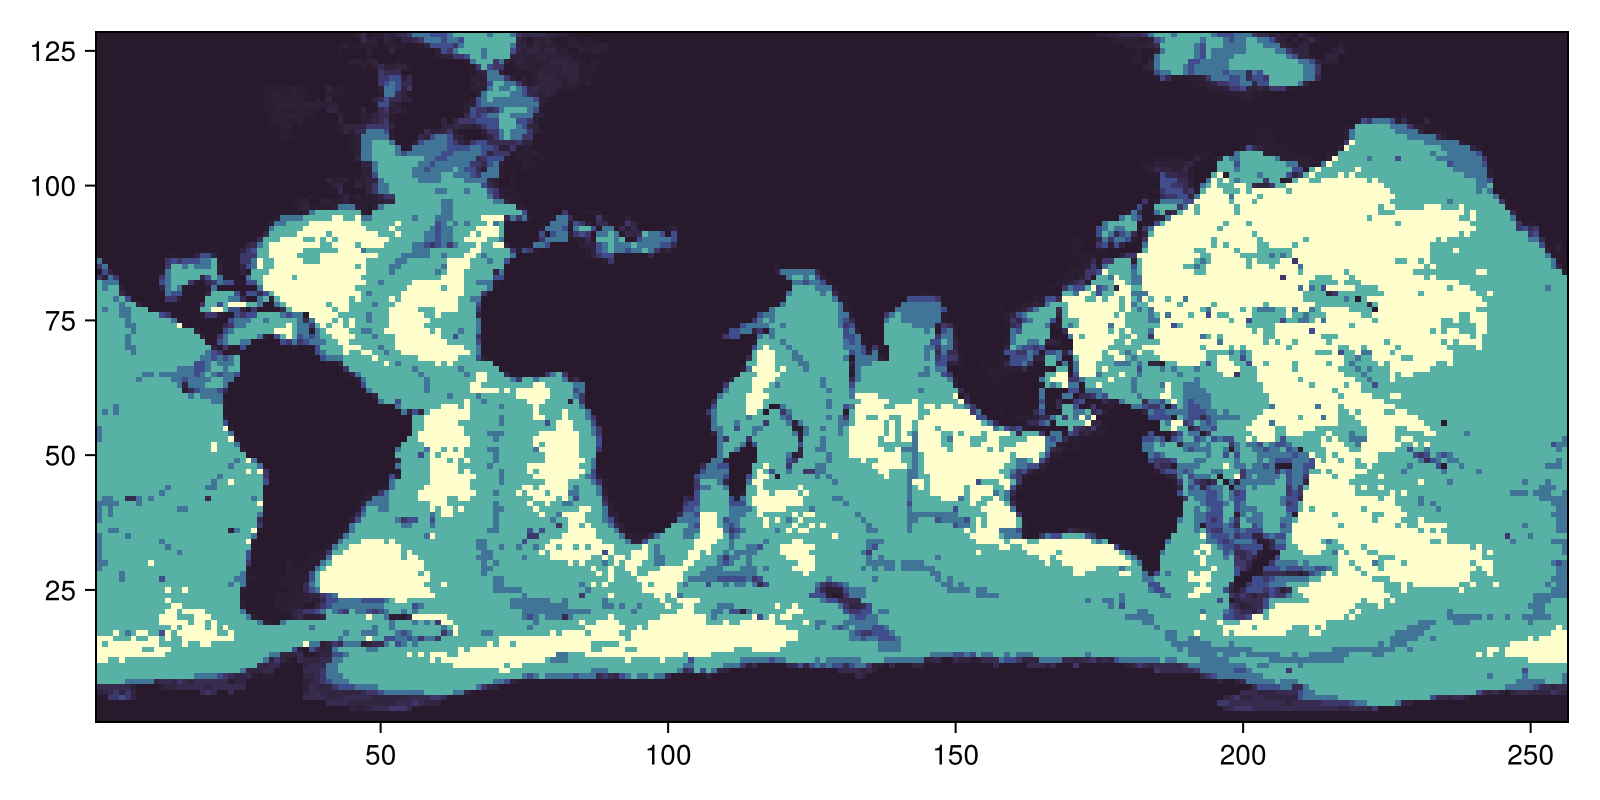

CairoMakie.Screen{IMAGE}


In [15]:
bottom_height = regrid_bathymetry(grid; minimum_depth=15, major_basins=1)

grid = ImmersedBoundaryGrid(underlying_grid, GridFittedBottom(bottom_height); active_cells_map=true)
fig = Figure(size = (800, 400))
ax  = Axis(fig[1, 1])
heatmap!(ax, interior(grid.immersed_boundary.bottom_height, :, :, 1), colormap=:deep)
display(fig)


# Configuring an Ocean model

### Numerical details

Oceananigans allows several numerical options.
We use a WENO schemes for the advection of momentum and
a centered scheme for tracer advection, to avoid implicit diapycnal diffusion of tracers.
Stability in the momentum field is ensured by the WENO method. For the tracer field, since the centered
scheme is dispersive, we need to add some explicit diffusion to avoid numerical instabilities.

In [16]:
# Centered(order = 2 - 12) (only even orders)
# UpwindBiased(order = 1 - 11) (only odd orders) 
# WENO(order = 3 - 11) (only odd orders, not higher than 9)
# VectorInvariant(scheme = EnergyConservingScheme() / EnstrophyConservingScheme())
# WENOVectorInvariant(vorticity_order, divergence_order, kinetic_energy_order, vertical_advection_order)

momentum_advection = WENOVectorInvariant(order=3)
tracer_advection   = Centered()

free_surface = SplitExplicitFreeSurface(grid; substeps=30)

SplitExplicitFreeSurface substepping with FixedSubstepNumber(21)


### Physical parameterizations

We add a GM parameterization for mesoscale eddies and a CATKE vertical mixing scheme.
All the closures require passing also the desired floating point precision of the model

In [17]:
using Oceananigans.TurbulenceClosures: IsopycnalSkewSymmetricDiffusivity
using Oceananigans.TurbulenceClosures.TKEBasedVerticalDiffusivities: CATKEVerticalDiffusivity

eddy_closure = IsopycnalSkewSymmetricDiffusivity(κ_skew=1e3, κ_symmetric=1e3)
vertical_mixing = CATKEVerticalDiffusivity()

closure = (eddy_closure, vertical_mixing)

(IsopycnalSkewSymmetricDiffusivity: (κ_symmetric=1000.0, κ_skew=1000.0, (isopycnal_tensor=Oceananigans.TurbulenceClosures.SmallSlopeIsopycnalTensor{Float64}(0.0), slope_limiter=Oceananigans.TurbulenceClosures.FluxTapering{Float64}(0.01)), CATKEVerticalDiffusivity{VerticallyImplicitTimeDiscretization}
├── maximum_tracer_diffusivity: Inf
├── maximum_tke_diffusivity: Inf
├── maximum_viscosity: Inf
├── minimum_tke: 1.0e-9
├── negative_tke_time_scale: 60.0
├── minimum_convective_buoyancy_flux: 1.0e-11
├── tke_time_step: Nothing
├── mixing_length: TKEBasedVerticalDiffusivities.CATKEMixingLength
│   ├── Cˢ:   1.131
│   ├── Cᵇ:   0.28
│   ├── Cʰⁱu: 0.242
│   ├── Cʰⁱc: 0.098
│   ├── Cʰⁱe: 0.548
│   ├── Cˡᵒu: 0.361
│   ├── Cˡᵒc: 0.369
│   ├── Cˡᵒe: 7.863
│   ├── Cᵘⁿu: 0.37
│   ├── Cᵘⁿc: 0.572
│   ├── Cᵘⁿe: 1.447
│   ├── Cᶜu:  3.705
│   ├── Cᶜc:  4.793
│   ├── Cᶜe:  3.642
│   ├── Cᵉc:  0.112
│   ├── Cᵉe:  0.0
│   ├── Cˢᵖ:  0.505
│   ├── CRiᵟ: 1.02
│   └── CRi⁰: 0.254
└── turbulent_kinetic_energy_

### Building the ocean simulation

ClimaOcean provides a utility to build an ocean simulation with all the necessary components.
The function `ocean_simulation` returns a `Simulation` object of a `HydrostaticFreeSurfaceModel` that has
all the necessary components (BC, drag, etc) to run a global ocean simulation.

In [ ]:
ocean = ocean_simulation(grid;
                         momentum_advection,
                         tracer_advection,
                         closure,
                         free_surface)

### Initialize our Ocean

We use ECCO climatology to initialize the temperature and salinity fields.
We can use the metadata we defined earlier to set the initial conditions.
We use ECCO climatology to initialize the temperature and salinity fields. 
We can use the metadata we defined earlier to set the initial conditions. 
To do this we need to be able to download ECCO data. This is done automatically by `ClimaOcean` 
provided that you have credentials to access the ECCO data. To do so, follow the instructions detailed in
**https://github.com/CliMA/ClimaOcean.jl/blob/main/src/DataWrangling/ECCO/README.md**.
If this is not possible I have prepared already inpainted files to use as initial conditions.
They can be donwloaded by uncommenting the following lines:

In [11]:
# download("https://www.dropbox.com/scl/fi/rcvf3ryegvxlm8gnga87l/SALT_1993_01_inpainted.jld2?rlkey=ctz2ty1yh6yksse1izd7l7ltd&st=skmv636j&dl=0", "./SALT_1993_01_inpainted.jld2")
# download("https://www.dropbox.com/scl/fi/3m9sw2lk149zgat6p8nil/SALT_1993_01.nc?rlkey=j1bz8zttg5n5lb1dhi547b2vh&st=ootshgfb&dl=0", "./SALT_1993_01.nc")
# download("https://www.dropbox.com/scl/fi/kmucmk4wb5cd1ckez6ts7/THETA_1993_01_inpainted.jld2?rlkey=v04dxmkgnrve5ob0boe6b52jp&st=wpdksush&dl=0", "./THETA_1993_01_inpainted.jld2")
# download("https://www.dropbox.com/scl/fi/6yzx1fvfk5b6ygyhi4sin/THETA_1993_01.nc?rlkey=euca05m5deb4kl8ylmg5nkasx&st=b4ooh3rd&dl=0", "./THETA_1993_01.nc")

In [ ]:
using ClimaOcean.ECCO

temperature = Metadatum(:temperature; dir="./", dataset=ECCO4Monthly())
salinity    = Metadatum(:salinity;    dir="./", dataset=ECCO4Monthly())

set!(ocean.model, T=temperature, S=salinity) 

### Visualizing the initial conditions

Let's visualize the surface of our initialized ocean model

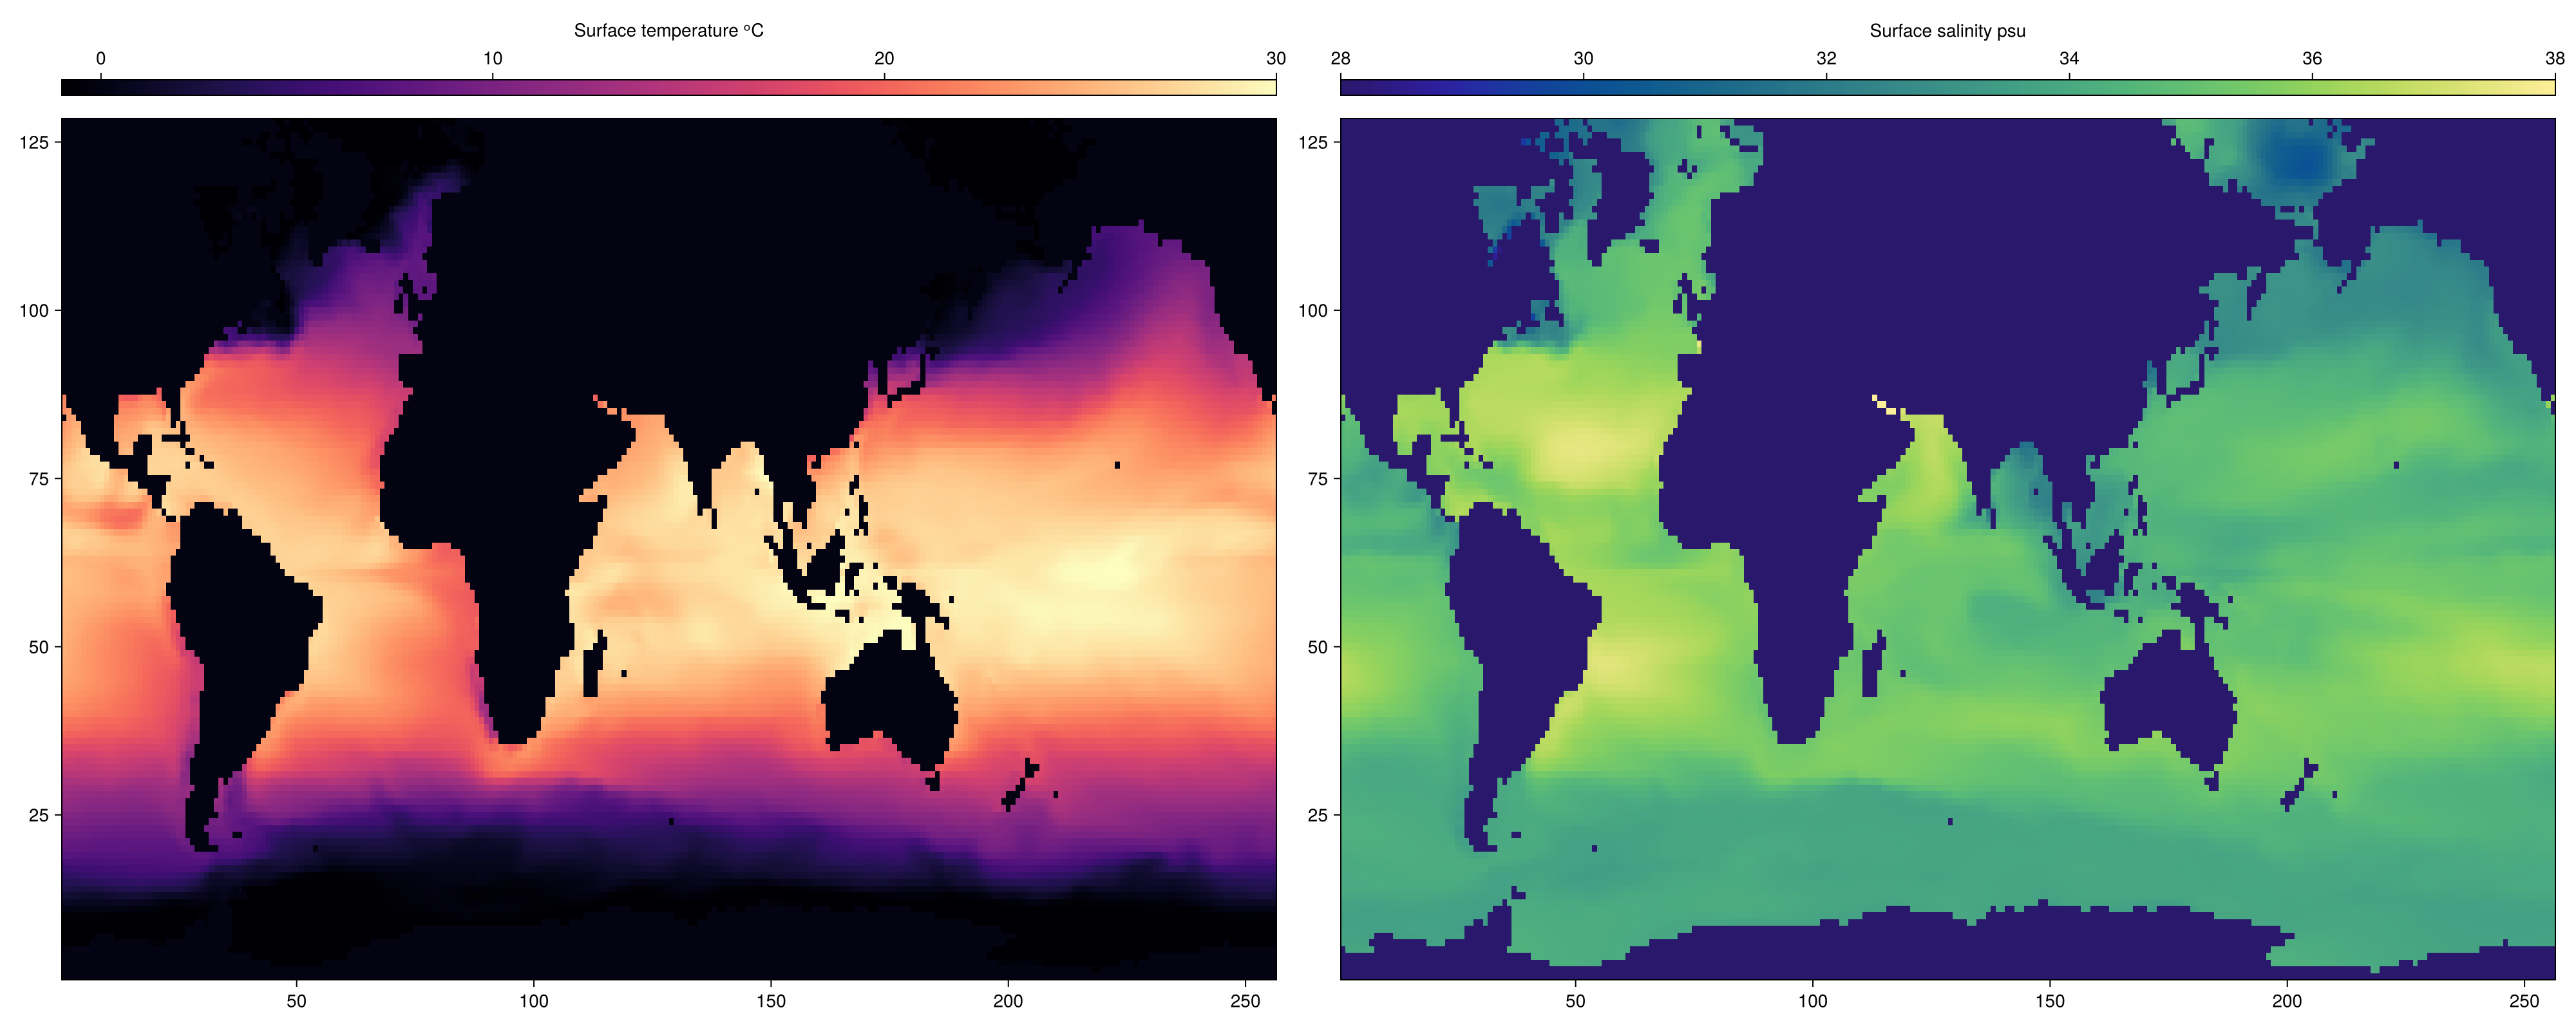

CairoMakie.Screen{IMAGE}


In [43]:
fig = Figure(size = (2000, 800))
axT = Axis(fig[1, 1])
axS = Axis(fig[1, 2])

hmT = heatmap!(axT, interior(ocean.model.tracers.T, :, :, grid.Nz), colorrange=(-1, 30), colormap=:magma)
hmS = heatmap!(axS, interior(ocean.model.tracers.S, :, :, grid.Nz), colorrange=(28, 38), colormap=:haline)
Colorbar(fig[0, 1], hmT, vertical=false, label="Surface temperature ᵒC")
Colorbar(fig[0, 2], hmS, vertical=false, label="Surface salinity psu")

display(fig)

# Adding an atmosphere

ClimaOcean is a prototype for a coupled earth system model.
It couples an atmosphere to an ocean and computes air-sea fluxes using bulk formulae.
At the moment, ClimaOcean provides a utility to download the JRA55 atmospheric reanalysis
and use it as a prescribed atmosphere.

!!! NOTE: This will download the JRA55 atmospheric reanalysis, so make sure that you have an internet connection (and enough disk space)

We use an idealized atmosphere for this tutorial to avoid downloading the JRA55 data (~15GB).

In [31]:
atmos_grid  = LatitudeLongitudeGrid(arch, Float32; size=(320, 200), latitude=(-90, 90), longitude=(0, 360), topology=(Periodic, Bounded, Flat))
atmos_times = range(0, 360Oceananigans.Units.days, length=10)
atmosphere  = PrescribedAtmosphere(atmos_grid, atmos_times)

320×200×1×10 PrescribedAtmosphere{Float32} on LatitudeLongitudeGrid:
├── times: 10-element StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
├── surface_layer_height: 10.0
└── boundary_layer_height: 600.0

We set up the atmosphere with an idealized temperature and wind speed that do not change in time.

In [32]:
Tₐ(λ, φ) = 220 + cosd(φ)^2 * 80
uₐ(λ, φ) = 10 * sind(2φ)^2
qₐ(λ, φ) = cosd(φ) * 3e-2

for t in eachindex(atmos_times)
    set!(atmosphere.tracers.T[t],    Tₐ)
    set!(atmosphere.tracers.q[t],    qₐ)
    set!(atmosphere.velocities.u[t], uₐ)

    Oceananigans.BoundaryConditions.fill_halo_regions!(atmosphere.tracers.T[t])
    Oceananigans.BoundaryConditions.fill_halo_regions!(atmosphere.tracers.q[t])
    Oceananigans.BoundaryConditions.fill_halo_regions!(atmosphere.velocities.u[t])
end

To use the JRA55 atmosphere, comment the above lines and uncomment the following line:


In [ ]:
atmosphere = JRA55PrescribedAtmosphere(arch; dir="./")

[ Info:  ... downloaded 17.0 B (100% complete, 3.265 days)
[ Info:  ... downloaded 17.0 B (100% complete, 3.265 days)
[ Info:  ... downloaded 17.0 B (100% complete, 3.265 days)
[ Info:  ... downloaded 535.2 MiB (30% complete, 3.265 days)
[ Info:  ... downloaded 713.6 MiB (40% complete, 3.265 days)
[ Info:  ... downloaded 892.0 MiB (50% complete, 3.265 days)
[ Info:  ... downloaded 1.0 GiB (60% complete, 3.265 days)
[ Info:  ... downloaded 1.2 GiB (70% complete, 3.265 days)
[ Info:  ... downloaded 1.4 GiB (80% complete, 3.265 days)
[ Info:  ... downloaded 1.6 GiB (90% complete, 3.266 days)
[ Info:  ... downloaded 1.7 GiB (100% complete, 3.266 days)


If we had a realistic atmosphere we would add radiative properties, however, since we do not have
downwelling radiation, we set it to nothing. If using a `JRA55PrescribedAtmosphere`, uncomment the first line and comment the second

In [34]:
# radiation = Radiation(ocean_albedo = LatitudeDependentAlbedo())
radiation = Radiation(ocean_albedo=1, ocean_emissivity=0) 

Radiation{Float64}:
├── stefan_boltzmann_constant: 5.67e-8
├── emission: SurfaceProperties
│   ├── ocean: 0.0
│   └── sea_ice: 0.0
└── reflection: SurfaceProperties
    ├── ocean: 1.0
    └── sea_ice: 0.7

### Coupling the atmosphere to the ocean

The `OceanSeaIceModel` is an `AbstractModel` defined in ClimaOcean that couples an ocean to an atmosphere and a sea ice component.
For the moment, the sea-ice component is not implemented, so we will only couple the ocean to the atmosphere.
Instead of the sea ice model, we limit the temperature of the ocean to the freezing temperature.

In [35]:
earth_model = OceanSeaIceModel(ocean; atmosphere, radiation)

OceanSeaIceModel{CPU}(time = 0 seconds, iteration = 0)
├── ocean: HydrostaticFreeSurfaceModel{CPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── atmosphere: 320×200×1×10 PrescribedAtmosphere{Float32}
├── sea_ice: FreezingLimitedOceanTemperature{ClimaSeaIce.SeaIceThermodynamics.LinearLiquidus{Float64}}
└── interface: ComponentInterfaces

### Building the simulation

We build the simulation out of the `earth_model` as we would do for any other Oceananigans model.
We start with a smallish time-step (5 minutes) and run only for 2 days to dissipate initialization shocks.

In [36]:
earth = Simulation(earth_model; Δt=30minutes, stop_time=30days)

Simulation of OceanSeaIceModel{CPU}(time = 0 seconds, iteration = 0)
├── Next time step: 30 minutes
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 30 days
├── Stop iteration: Inf
├── Wall time limit: Inf
├── Minimum relative step: 0.0
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u_ocean on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

### Adding some diagnostics

We add a callback to save surface fields as well as surface fluxes, every 6 hours

In [37]:
u, v, _ = ocean.model.velocities
T = ocean.model.tracers.T
S = ocean.model.tracers.S
s = sqrt(u^2 + v^2)

η = ocean.model.free_surface.η

earth.output_writers[:surface_tracers] = JLD2OutputWriter(ocean.model, (; T, S, s),
                                                          schedule = TimeInterval(12hours),
                                                          indices = (:, :, grid.Nz),
                                                          overwrite_existing = true,
                                                          filename = "surface_fields.jld2")


earth.output_writers[:free_surface] = JLD2OutputWriter(ocean.model, (; η),
                                                       schedule = TimeInterval(12hours),
                                                       overwrite_existing = true,
                                                       filename = "free_surface.jld2")

Q  = earth.model.interfaces.net_fluxes.ocean_surface.Q
τx = earth.model.interfaces.net_fluxes.ocean_surface.u
τy = earth.model.interfaces.net_fluxes.ocean_surface.v
PE = earth.model.interfaces.net_fluxes.ocean_surface.S

earth.output_writers[:fluxes] = JLD2OutputWriter(ocean.model, (; Q, τx, τy, PE),
                                                 schedule = TimeInterval(12hours),
                                                 overwrite_existing = true,
                                                 filename = "surface_fluxes.jld2")

JLD2OutputWriter scheduled on TimeInterval(12 hours):
├── filepath: surface_fluxes.jld2
├── 4 outputs: (Q, τx, τy, PE)
├── array type: Array{Float32}
├── including: [:grid, :coriolis, :buoyancy, :closure]
├── file_splitting: NoFileSplitting
└── file size: 54.3 MiB

Also, we add a callback to print a message about how the simulation is going

In [38]:
wall_time = [time_ns()]

function progress(earth)
    clock   = earth.model.clock

    maxu = maximum(abs, u)
    maxv = maximum(abs, v)
    maxT = maximum(T)
    minS = minimum(S)

    @info @sprintf("Iteration: %d, time: %s, wall_time: %s, max(|u|, |v|): %.2e %.2e max(T): %.2e, min(S): %.2e\n",
                   clock.iteration, prettytime(clock.time), prettytime(1e-9 * (time_ns() - wall_time[1])), maxu, maxv, maxT, minS)

    wall_time[1] = time_ns()
end

add_callback!(earth, progress, IterationInterval(10))

### Running the simulation

quite simply

In [39]:
run!(earth)

[ Info: Initializing simulation...
[ Info: Iteration: 0, time: 0 seconds, wall_time: 16.698 seconds, max(|u|, |v|): 0.00e+00 0.00e+00 max(T): 3.09e+01, min(S): 2.79e+01
[ Info:     ... simulation initialization complete (22.776 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (14.165 seconds).
[ Info: Iteration: 10, time: 5 hours, wall_time: 24.838 seconds, max(|u|, |v|): 8.05e-01 9.87e-01 max(T): 3.09e+01, min(S): 2.79e+01
[ Info: Iteration: 20, time: 10 hours, wall_time: 3.845 seconds, max(|u|, |v|): 1.09e+00 1.49e+00 max(T): 3.09e+01, min(S): 2.79e+01
[ Info: Iteration: 30, time: 15 hours, wall_time: 3.673 seconds, max(|u|, |v|): 9.97e-01 1.88e+00 max(T): 3.09e+01, min(S): 2.79e+01
[ Info: Iteration: 40, time: 20 hours, wall_time: 3.677 seconds, max(|u|, |v|): 9.34e-01 1.93e+00 max(T): 3.08e+01, min(S): 2.79e+01
[ Info: Iteration: 50, time: 1.042 days, wall_time: 3.645 seconds, max(|u|, |v|): 1.01e+00 1.74e+00 max(T): 3.08e+01, min(S): 2.79e

## Visualizing the results

We can visualize the results using CairoMakie. We record a video of surface variables and fluxes.
To load the data we can use Oceananigans' `FieldTimeSeries` object.

In [ ]:
using JLD2
using Oceananigans
using Oceananigans.Grids: halo_size
using CairoMakie
using Statistics: mean

file  = jldopen("free_surface.jld2")
iters = keys(file["timeseries/t"])

Hx, Hy, _ = halo_size(η.grid)
T  = FieldTimeSeries("surface_fields.jld2", "T")
S  = FieldTimeSeries("surface_fields.jld2", "S")
s  = FieldTimeSeries("surface_fields.jld2", "s")

n  = Observable(1)
Tn = @lift(interior(T[$n], :, :, 1))
Sn = @lift(interior(S[$n], :, :, 1))
sn = @lift(interior(s[$n], :, :, 1))
ηn = @lift(file["timeseries/η/" * iters[$n]][Hx+1:end-Hx, Hy+1:end-Hy, 1])

fig = Figure(size = (1800, 800))
axT = Axis(fig[1, 1], title="Surface temperature ᵒC")
axS = Axis(fig[1, 2], title="Surface salinity psu")
axs = Axis(fig[2, 1], title="Surface speed ms⁻¹")
axη = Axis(fig[2, 2], title="Sea surface height m")

λ, φ, z = nodes(T[1])

hmT = heatmap!(axT, Tn, colormap=:magma,  colorrange=(-1, 30))
hmS = heatmap!(axS, Sn, colormap=:haline, colorrange=(25, 40))
hms = heatmap!(axs, sn, colormap=:deep,   colorrange=( 0, 0.8))
hmη = heatmap!(axη, ηn, colormap=:bwr,    colorrange=(-1, 1))

CairoMakie.record(fig, "surface_fields.gif", 1:length(T.times); framerate=5) do i
    @info "doing $i of $(length(T.times))"
    n[] = i
end

In [ ]:
display(MIME"image/png"(), read(open("surface_fields.gif")))

let's also visualize the surface fluxes that force the model

In [ ]:
Q  = FieldTimeSeries("surface_fluxes.jld2", "Q")
τx = FieldTimeSeries("surface_fluxes.jld2", "τx")
τy = FieldTimeSeries("surface_fluxes.jld2", "τy")
PE = FieldTimeSeries("surface_fluxes.jld2", "PE")

Qn  = @lift(interior(Q[$n],  :, :, 1))
τxn = @lift(interior(τx[$n], :, :, 1))
τyn = @lift(interior(τy[$n], :, :, 1))
PEn = @lift(interior(PE[$n], :, :, 1))

fig  = Figure(size = (1800, 800))
axQ  = Axis(fig[1, 1], title="Net heat flux Wm⁻²")
axPE = Axis(fig[1, 2], title="Net salt flux psu m s⁻¹")
axτx = Axis(fig[2, 1], title="Zonal wind stress Nm⁻²")
axτy = Axis(fig[2, 2], title="Meridional wind stress Nm⁻²")

hmQ  = heatmap!(axQ,  Qn,  colormap=:magma,   colorrange=(-800,  800))
hmPE = heatmap!(axPE, PEn, colormap=:haline,  colorrange=(-1e-5, 5e-5))
hmτx = heatmap!(axτx, τxn, colormap=:balance, colorrange=(-5e-4, 5e-4))
hmτy = heatmap!(axτy, τyn, colormap=:balance, colorrange=(-5e-4, 5e-4))

CairoMakie.record(fig, "surface_fluxes.mp4", 1:length(Q.times); framerate=5) do i
    @info "doing $i of $(length(Q.times))"
    n[] = i
end

Let's visualize the internal structure of temperature and salinity

In [ ]:
x, y, z = nodes(ocean.model.tracers.T)

fig = Figure(size = (1200, 400))
axT = Axis(fig[1, 1], title="Internal temperature structure ᵒC")
axS = Axis(fig[1, 2], title="Internal salinity structure psu")

contourf!(axT, 1:128, z, interior(mean(ocean.model.tracers.T, dims=1), 1, :, :), colormap=:magma)
contourf!(axS, 1:128, z, interior(mean(ocean.model.tracers.S, dims=1), 1, :, :), colormap=:haline)
display(fig)

# Running a high-resolution simulation

What are the steps to modify the above script to run an eddying (quarter degree) simulation?